In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

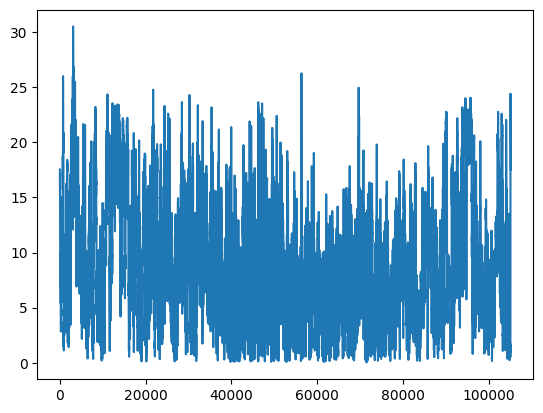

In [3]:
#一号风机的风速
df = pd.read_csv('../0.csv',skiprows=1)
wspd = df['wind speed at 100m (m/s)'].fillna(0).to_numpy().reshape(-1)
plt.plot(wspd)
plt.show()

平稳序列通常具有短期相关性，对于平稳的时间序列，自相关系数往往会迅速退化到零（滞后期越短相关性越高，滞后期为0时，相关性为1）；而对于非平稳的数据，退化会发生得更慢，或存在先减后增或者周期性的波动等变动。

根据ACF求出滞后k自相关系数时，实际上得到并不是X(t)与X(t-k)之间单纯的相关关系。
因为X(t)同时还会受到中间k-1个随机变量X(t-1)、X(t-2)、……、X(t-k+1)的影响，而这k-1个随机变量又都和X(t-k)具有相关关系，所以自相关系数里面实际掺杂了其他变量对X(t)与X(t-k)的影响。 在剔除了中间k-1个随机变量X(t-1)、X(t-2)、……、X(t-k+1)的干扰之后，X(t-k)对X(t)影响的相关程度，叫偏自相关系数。不同滞后期得到的偏自相关系数，叫偏自相关图。

Text(0.5, 1.0, 'PACF(wind speed)')

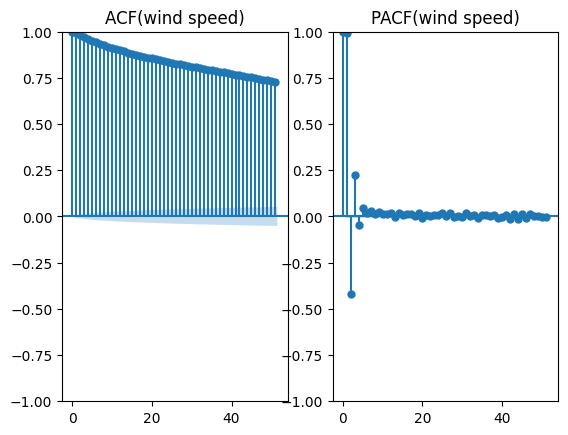

In [12]:
#自相关图检验ACF,PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2)   
fig.subplots_adjust(hspace=0.5)
plot_acf(wspd, ax=ax[0])
ax[0].set_title('ACF(wind speed)')
plot_pacf(wspd, ax=ax[1])
ax[1].set_title('PACF(wind speed)')

宽平稳中有两个条件是均值不变和方差不变，可视化数据中我们可以直观看出来,直接将序列前后拆分成2个序列，分别计算这2个序列的均值、方差，对比看是否差异明显。

In [23]:
#序列不同时间段的均值、方差
def describe(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

print('wind speed:')
print('mean=%f,variance=%f' % (wspd.mean(),wspd.var()))
describe(wspd)

wind speed:
mean=8.806834,variance=25.742061
mean1=9.690084, mean2=7.923584
variance1=28.281314, variance2=21.642546


## 假设检验法
平稳性的假设检验方法当前主流为单位根检验，检验序列中是否存在单位根，若存在，则为非平稳序列，不存在则为平稳序列。
### DF检验
ADF检验（Augmented Dickey-Fuller Testing）是最常用的单位根检验方法之一，通过检验序列是否存在单位根来判断序列是否是平稳的。ADF检验是DF检验的增强版。

迪基（Dickey）和弗勒（Fuller）1979年基于非平稳序列的基本特征将其大致归为三类并提出DF检验：
(1) 当序列基本走势呈现无规则上升或下降并反复时，将其归为**无漂移项自回归**过程；
(2) 当序列基本走势呈现明显的随时间递增或递减且趋势并不太陡峭时，将其归为**带漂移项自回归过程**；
(3) 当序列基本走势随时间快速递增时，则将其归为**带趋势项回归过程**。

DF的检验公式为一阶自回归过程，为了能适用于高阶自回归过程的平稳性检验，迪基等1984年对DF检验进行了一定的修正，引入了更高阶的滞后项


In [24]:
#ADF平稳性检验风速
from statsmodels.tsa.stattools import adfuller
testResult = adfuller(wspd)
print(testResult)

(-14.88599945971699, 1.5832090971184503e-27, 69, 105050, {'1%': -3.4304122509262043, '5%': -2.8615675139486747, '10%': -2.5667846447095637}, 149451.73457854614)


1. -14.88599945971699 同时小于 '1%': -3.4304122509262043, '5%': -2.8615675139486747, '10%': -2.5667846447095637说明是平稳的
2. 1.5832090971184503e-27非常接近0，是平稳的

In [15]:
#ADF平稳性检验风速2
from arch.unitroot import ADF
adf = ADF(wspd)
print(adf.summary().as_text)

adf = ADF(wspd,trend='ct')
print(adf.summary().as_text)

<bound method Summary.as_text of <class 'statsmodels.iolib.summary.Summary'>
"""
   Augmented Dickey-Fuller Results   
Test Statistic                -14.886
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""">
<bound method Summary.as_text of <class 'statsmodels.iolib.summary.Summary'>
"""
   Augmented Dickey-Fuller Results   
Test Statistic                -15.097
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""">


## PP检测
Phillips和Perron(1988) 提出一种非参数检验方法，主要是为了解决残差项中潜在的序列相关和异方差问题，其检验统计量的渐进分布和临界值与 ADF检验相同。同样出现较早，假设条件一样，用法相似，可作为ADF检验的补充。

In [16]:
#风速，风功率pp检验
from arch.unitroot import PhillipsPerron
pp = PhillipsPerron(wspd)
print(pp.summary().as_text())

pp = PhillipsPerron(wspd,trend='ct')
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.604
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.842
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## DF-GLS检验
DF-GLS检验，是Elliott, Rothenberg, and Stock 1996年提出的一种单位根检验方法，全称Dickey-Fuller Test with GLS Detredding，即“使用广义最小二乘法去除趋势的检验”，是目前最有功效的单位根检验。

DF-GLS检验利用广义最小二乘法，首先对要检验的数据进行一次“准差分”，然后利用准差分的数据对原序列进行去除趋势处理，再利用ADF检验的模型形式对去除趋势后的数据进行单位根检验，但此时ADF检验模型中不再包含常数项或者时间趋势变量。

In [20]:
#DFGLS检测风速
from arch.unitroot import DFGLS
dfgls = DFGLS(wspd)
print(dfgls.summary().as_text())

dfgls = DFGLS(wspd,trend='ct')
print(dfgls.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -6.975
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                -11.348
P-value                         0.000
Lags                               69
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## KPSS检验
另一个著名的单位根存在的检验是Kwiatkowski, Phillips, and Shin 1992年提出的KPSS检验。与以上三种检验方法相比，最大的不同点就是它的原假设是平稳序列或趋势平稳序列，而备择假设是存在单位根。

In [25]:
#KPSS检验风速 p>0.05
from arch.unitroot import KPSS
kpss = KPSS(wspd)
print(kpss.summary().as_text())

kpss = KPSS(wspd,trend='ct')
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  4.661
P-value                         0.000
Lags                              190
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  2.593
P-value                         0.000
Lags                              190
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [26]:
#kpss 2
from statsmodels.tsa.stattools import kpss
result = kpss(wspd)
print(result)

(4.660808432823206, 0.01, 190, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\92469\AppData\Local\Temp\ipykernel_22316\795166375.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(wspd)
